# 質感カメラ

## 位置合わせ・差分処理用の関数を書く

In [15]:
import cv2
import numpy as np
 
def get_keypoints(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    akaze = cv2.AKAZE_create()
    return akaze.detectAndCompute(gray, None)

def get_matches(img, kp2, des2):
    kp1, des1 = get_keypoints(img)
    if len(kp1) == 0 or len(kp2) == 0:
        return None
    matches = cv2.BFMatcher().knnMatch(des1, des2, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.6 * n.distance:
            good.append(m)
    if len(good) ==0:
        return None
    base_position = []   # 基準画像
    target_position = [] # 対象画像
    for g in good:       # 各画像の対応点[x,y座標]を格納
        base_position.append(   [kp2[g.trainIdx].pt[0], kp2[g.trainIdx].pt[1]])
        target_position.append( [kp1[g.queryIdx].pt[0], kp1[g.queryIdx].pt[1]])    
    return np.array(target_position), np.array(base_position)

def get_alignment_img(img, kp2, des2):
    height, width = img.shape[:2]
    apt1, apt2 = get_matches(img, kp2, des2)
    affine_mtx = cv2.estimateAffinePartial2D(apt1, apt2)[0]
    if affine_mtx is not None:
        return cv2.warpAffine(img, affine_mtx, (width, height))
    else:
        return None

## まずは動画中の全フレームを読み込む

In [16]:
# 動画は、真上を向いているところが反射している状態からスタートしている、とする
in_file = "MVI_0191.MOV" # 入力映像ファイル名
cap = cv2.VideoCapture( in_file ) # 動画ファイルを開く
w = round( cap.get(cv2.CAP_PROP_FRAME_WIDTH) ) # 動画の縦横を取得
h = round( cap.get(cv2.CAP_PROP_FRAME_HEIGHT) )
min_image = np.empty([h,w])# 最小値画像
max_image = np.empty([h,w])# 最大値画像
dir_image = np.empty([h,w])# 最大値方向
frames = []    # 冒頭フレームを基準に、刻々のフレームを位置合わせ＆格納する
is_1st = True  # 冒頭フレームか否かを判定する
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 
        if is_1st:
            frames.append(frame); is_1st = False
            kp, des = get_keypoints(frame)# 基準画像の特徴点・特徴記述子
        else: # 対象画像を（基準画像に対し）位置合わせした画像を作成・追加
            aligned_image = get_alignment_img(frame, kp, des)
            frames.append(aligned_image)
    else:
        break
cap.release()

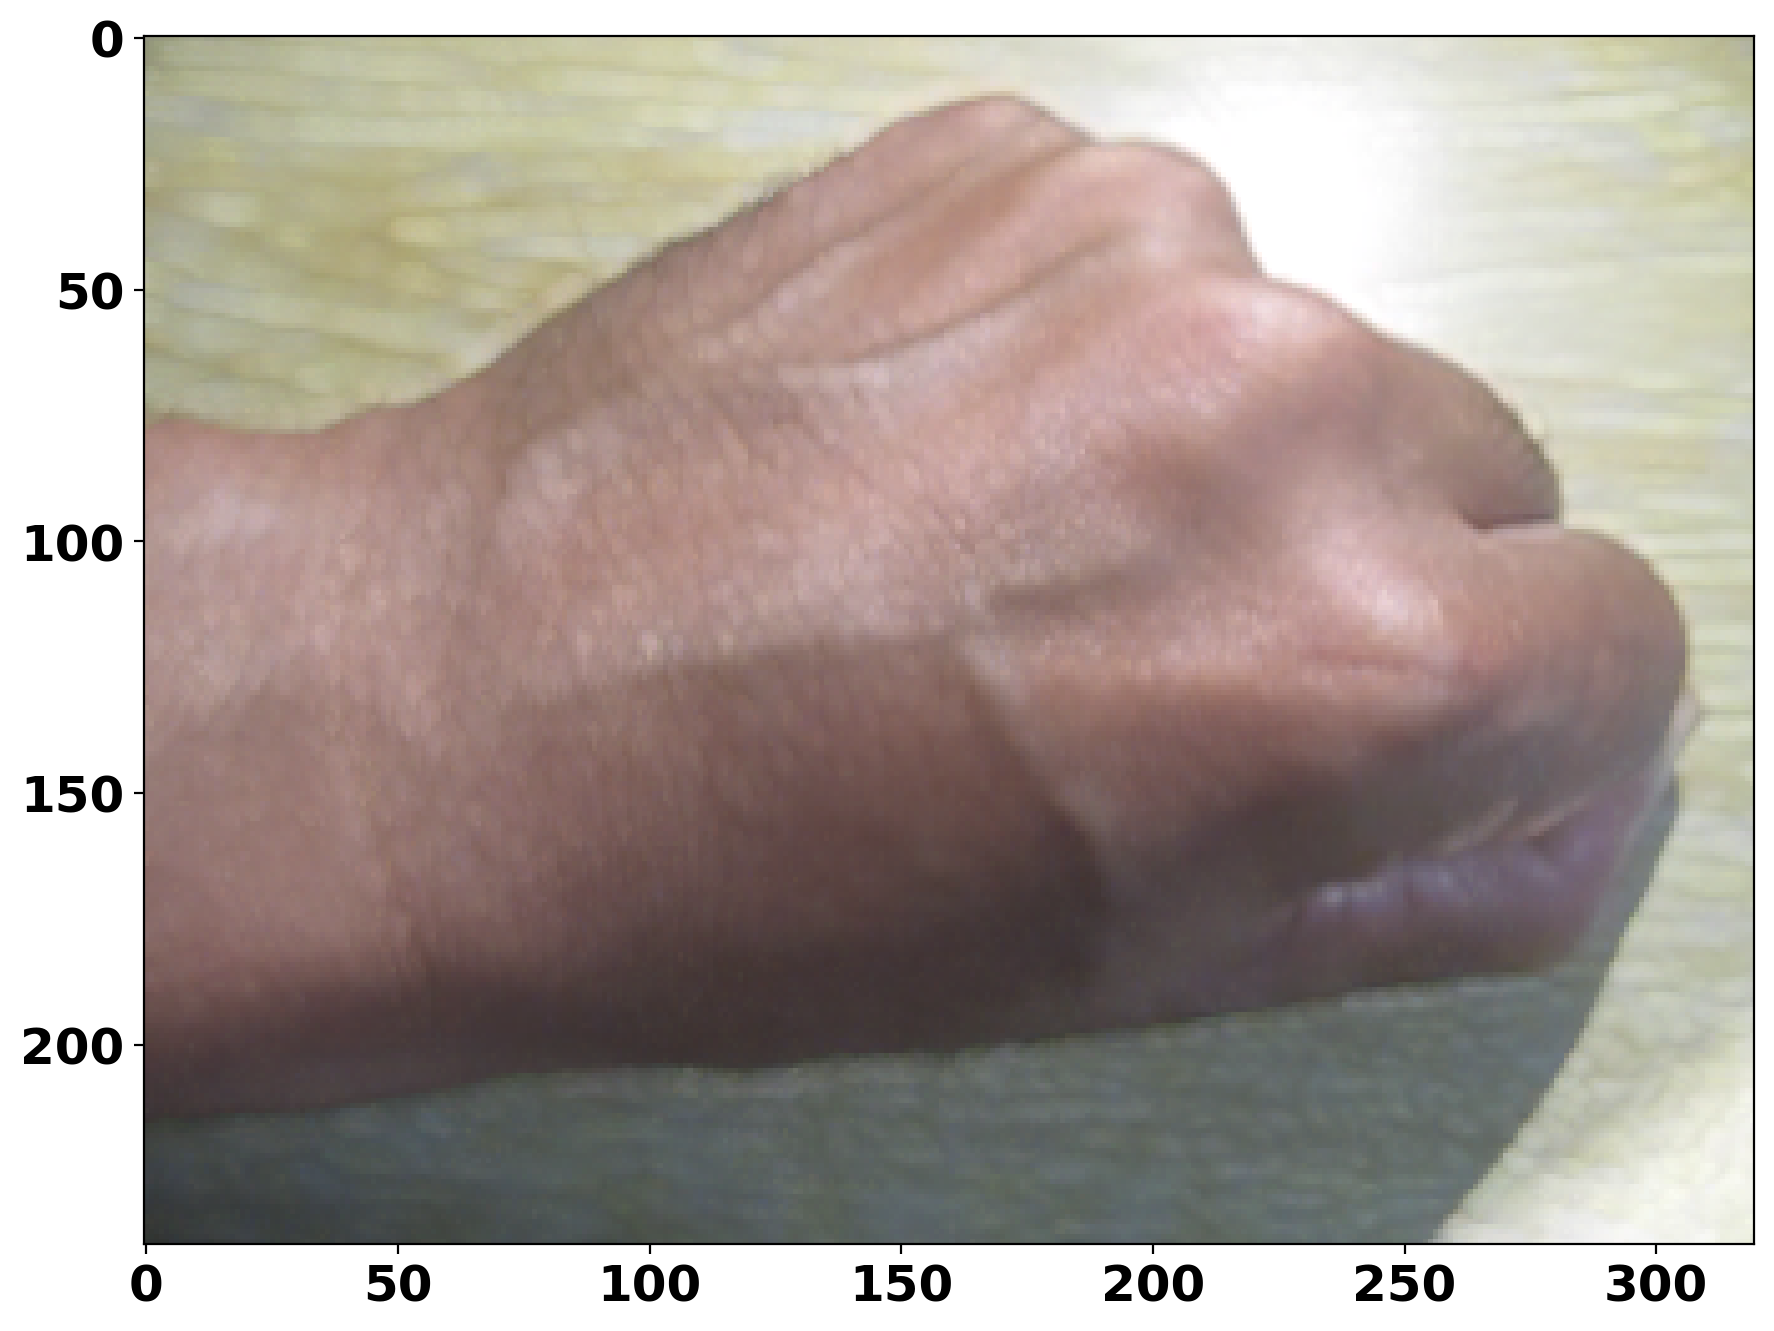

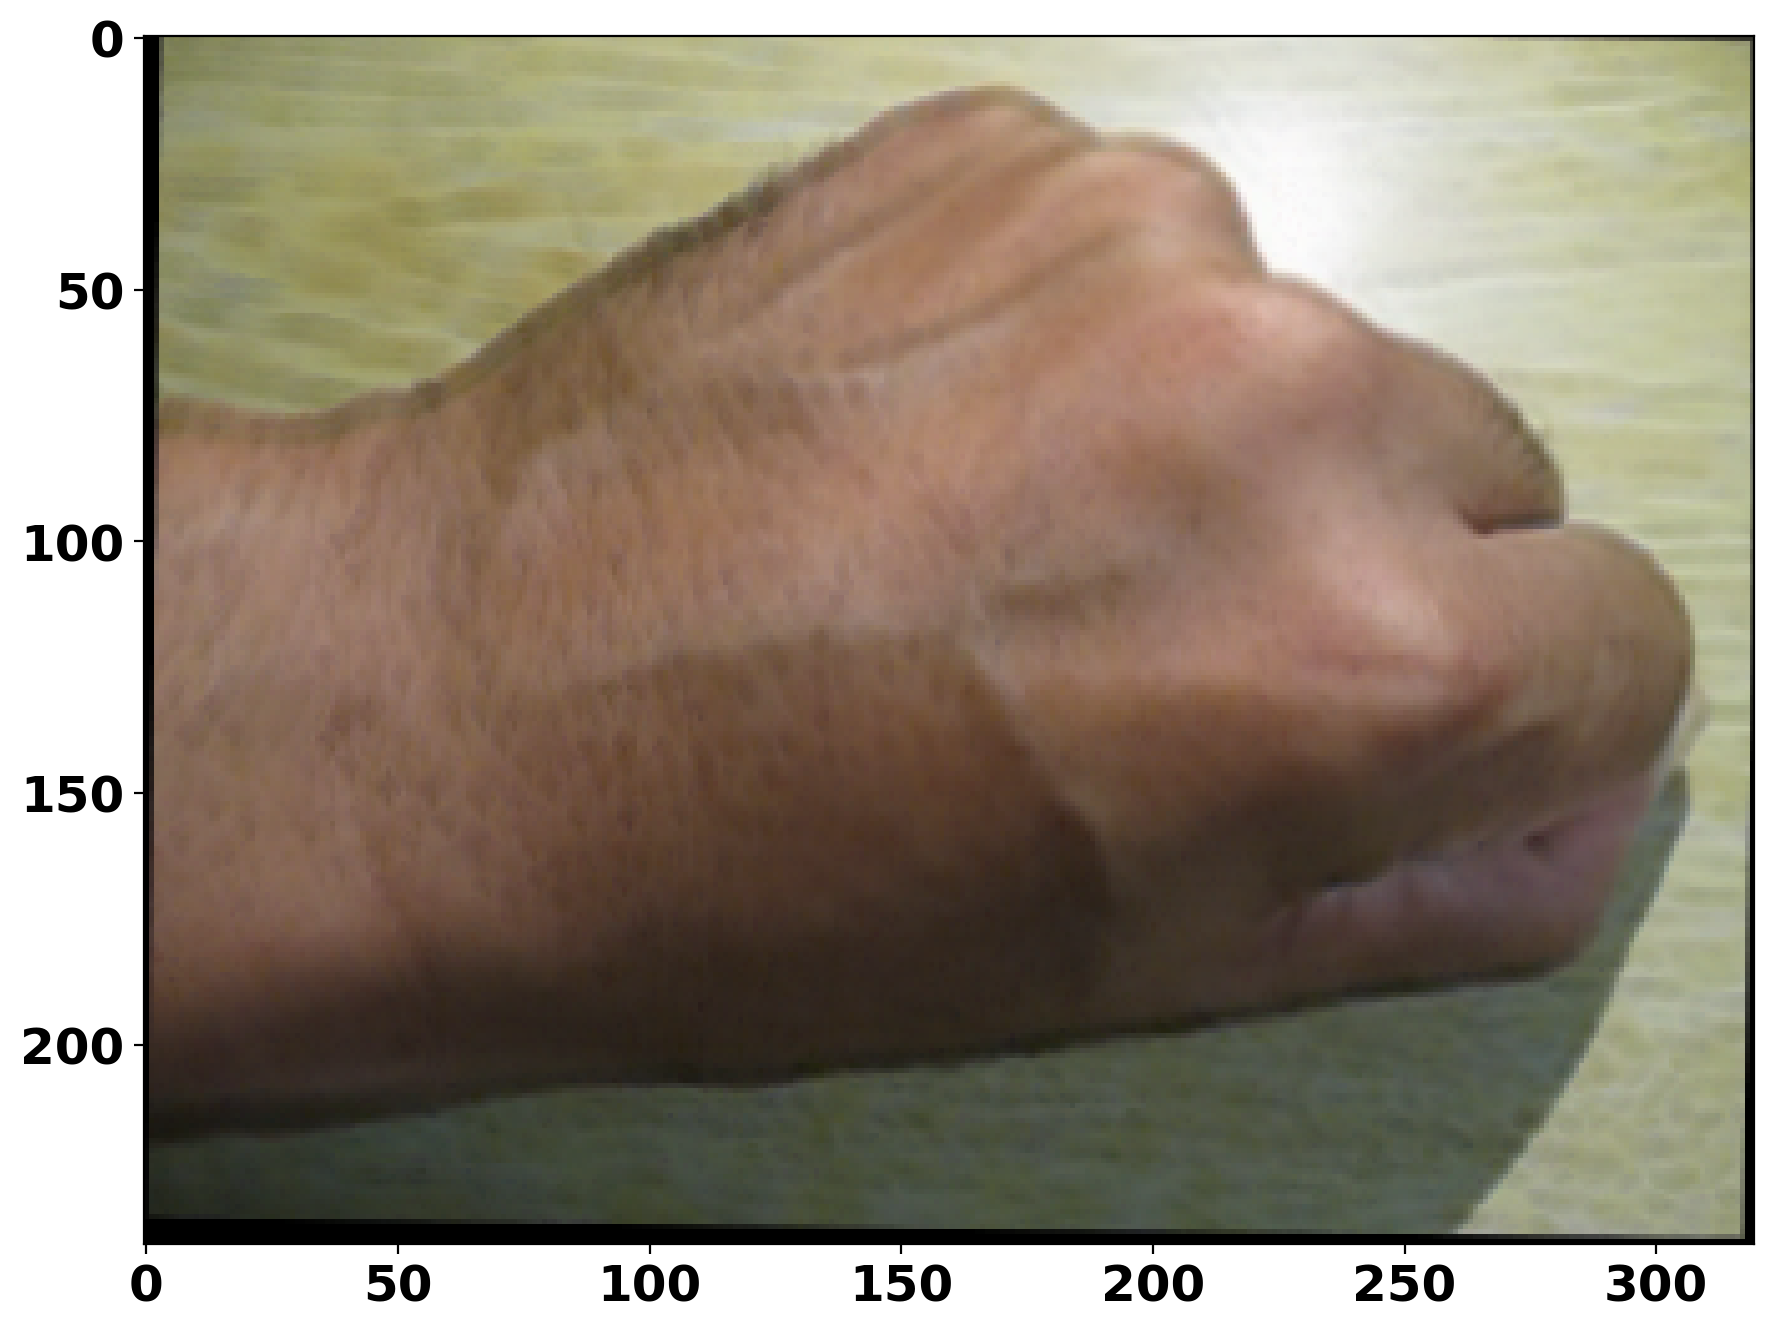

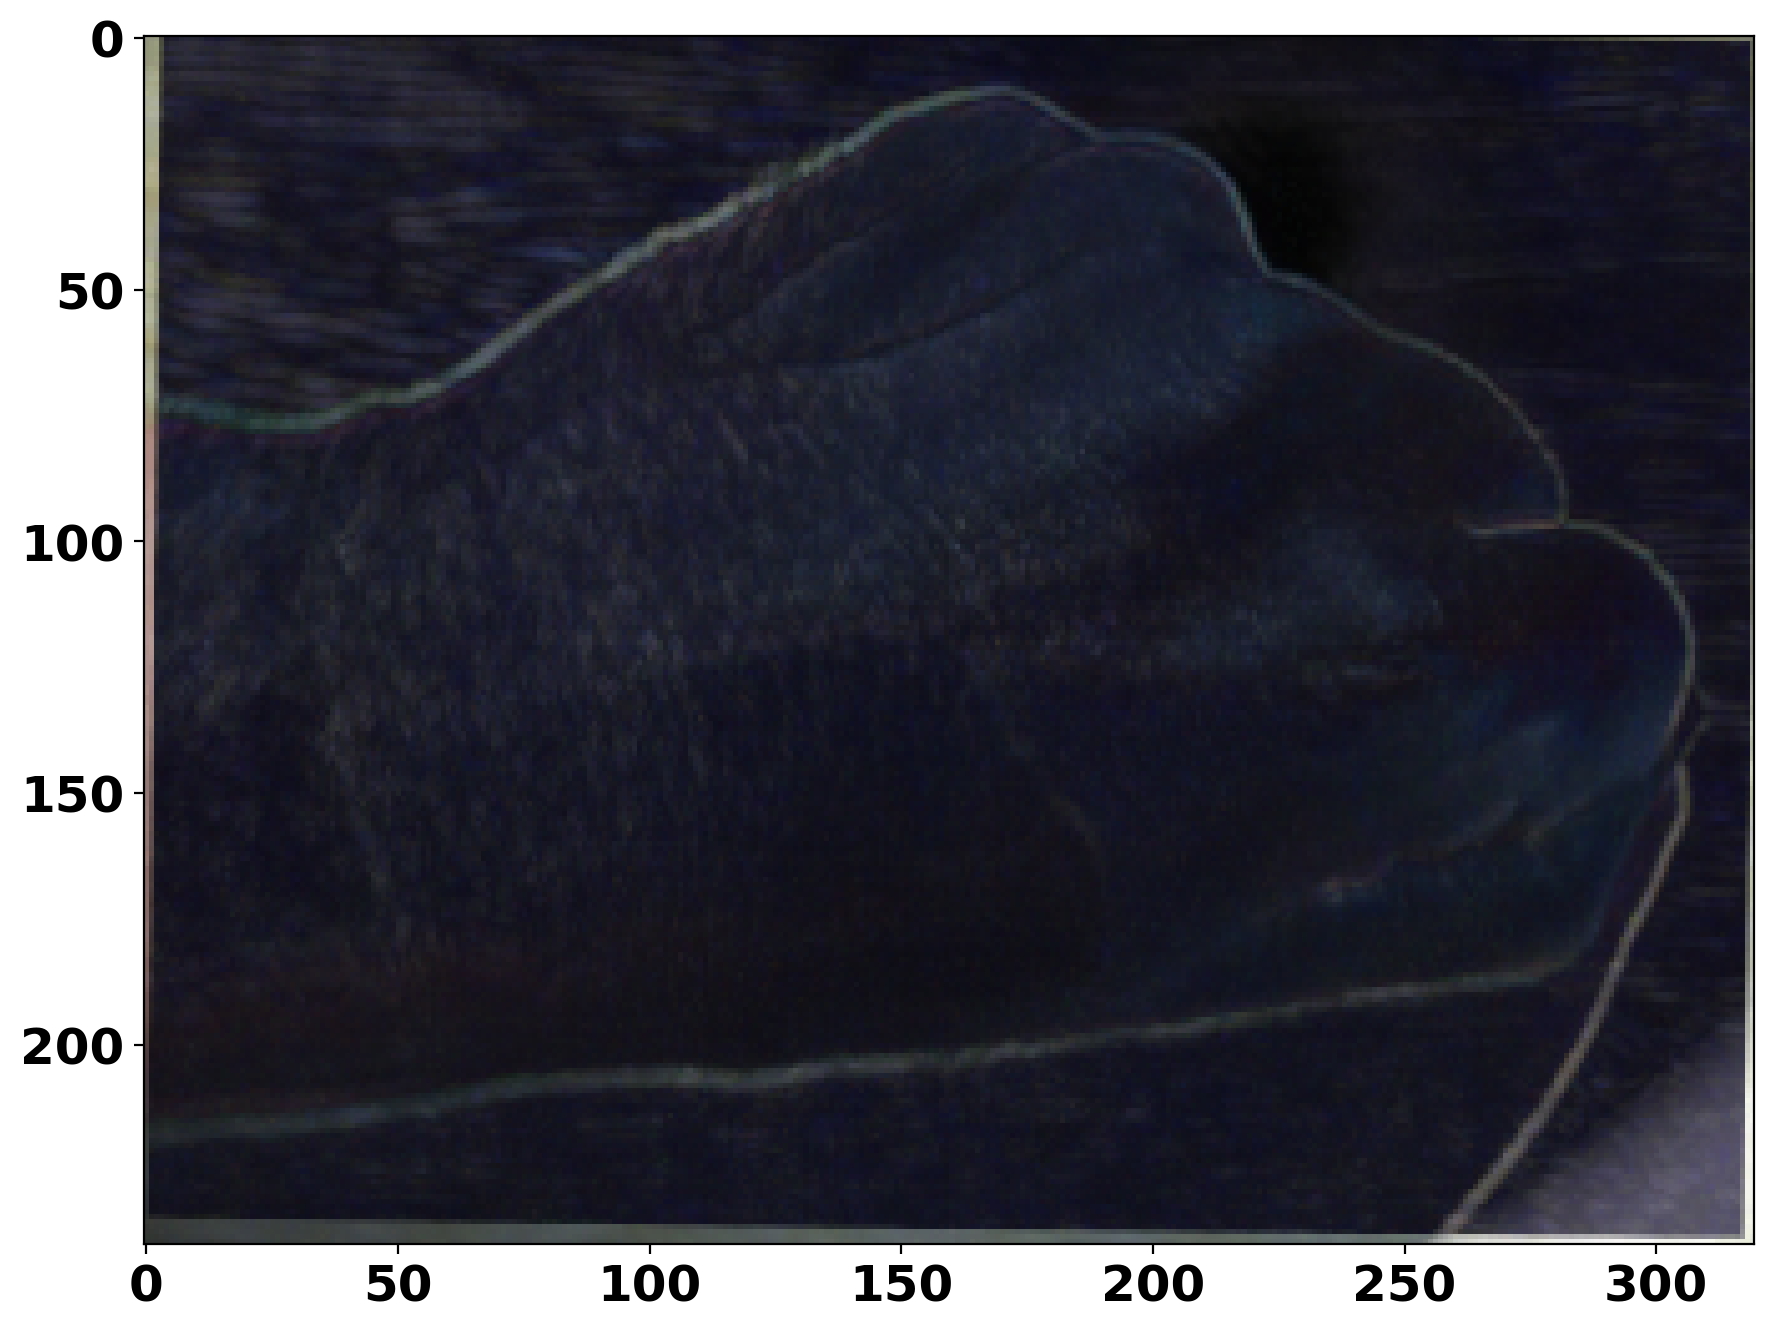

In [23]:
# 最大・最小画像・反射光成分抽出は、全フレーム(時間)領域を使う
max_img = np.max(frames, axis=0) # 最も明るい画素で作った画像
min_img = np.min(frames, axis=0) # 最も暗い画素で作った画像
spc_img = max_img - min_img      # 表面での鏡面反射成分

#plt.imshow(max_img);plt.show()
#plt.imshow(min_img);plt.show()
#plt.imshow(spc_img);plt.show()


plt.rcParams["font.size"] = 18
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.figure(figsize=(12,8), dpi=200 )
plt.imshow(max_img);plt.show()
plt.figure(figsize=(12,8), dpi=200 )
plt.imshow(min_img);plt.show()
plt.figure(figsize=(12,8), dpi=200 )
plt.imshow(spc_img);plt.show()



In [ ]:
def estimate_period(signal): # 周期算出関数
    window = 1; w = np.ones(window)/window # 移動平均Window
    smooth = np.convolve(signal, w, mode='same')
    corr = np.correlate(smooth, smooth, 'same')
    period = np.argmax(corr)
    return (period, smooth, corr)

max_point: (169, 0, 1)
22


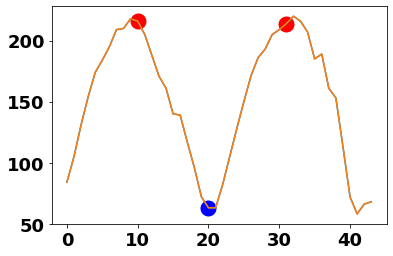

In [44]:
# 反射光成分が最大の画素位置
max_spc_at = np.unravel_index(np.argmax(spc_img), spc_img.shape)
print("max_point: {}".format(max_spc_at))
# 反射光成分が最大の画素位置での時系列
profile = frames[:, max_spc_at[0], max_spc_at[1], 1] # G ch.で最大値検出
# 周期を求める
maxpoint1_idx = np.argmax(profile)
period, smooth, corr = estimate_period(profile)
print(period)
# 位相計算に使うフレーム(時間)領域を定める
if len(frames)/2 < maxpoint1_idx:
    start_idx = maxpoint1_idx-period
    end_idx = maxpoint1_idx-1
else:
    start_idx = maxpoint1_idx
    end_idx = maxpoint1_idx+period-1
plt.scatter(start_idx, profile[start_idx],c='red',marker='o',linewidths=10)
plt.scatter(end_idx, profile[end_idx], c='red', marker='o', linewidths=10)
idx = int((start_idx+end_idx)/2)
plt.scatter(idx, profile[idx], c='blue', marker='o', linewidths=10)
plt.plot(smooth); plt.plot(profile); plt.show()

## 内部拡散色を表示してみる

In [11]:
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

def show_image(ratio):
    plt.imshow((min_img+ratio*spc_img)/255)
    plt.show()
    
slider = FloatSlider(min=-2.0, max=2.0, step=0.01)
#display(slider)
#slider.observe(show_image, names='value')
#display(slider)

## 法線方向を可視化する

### 法線方向を可視化する

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


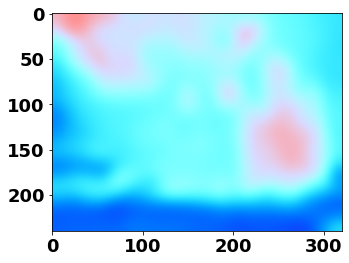

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


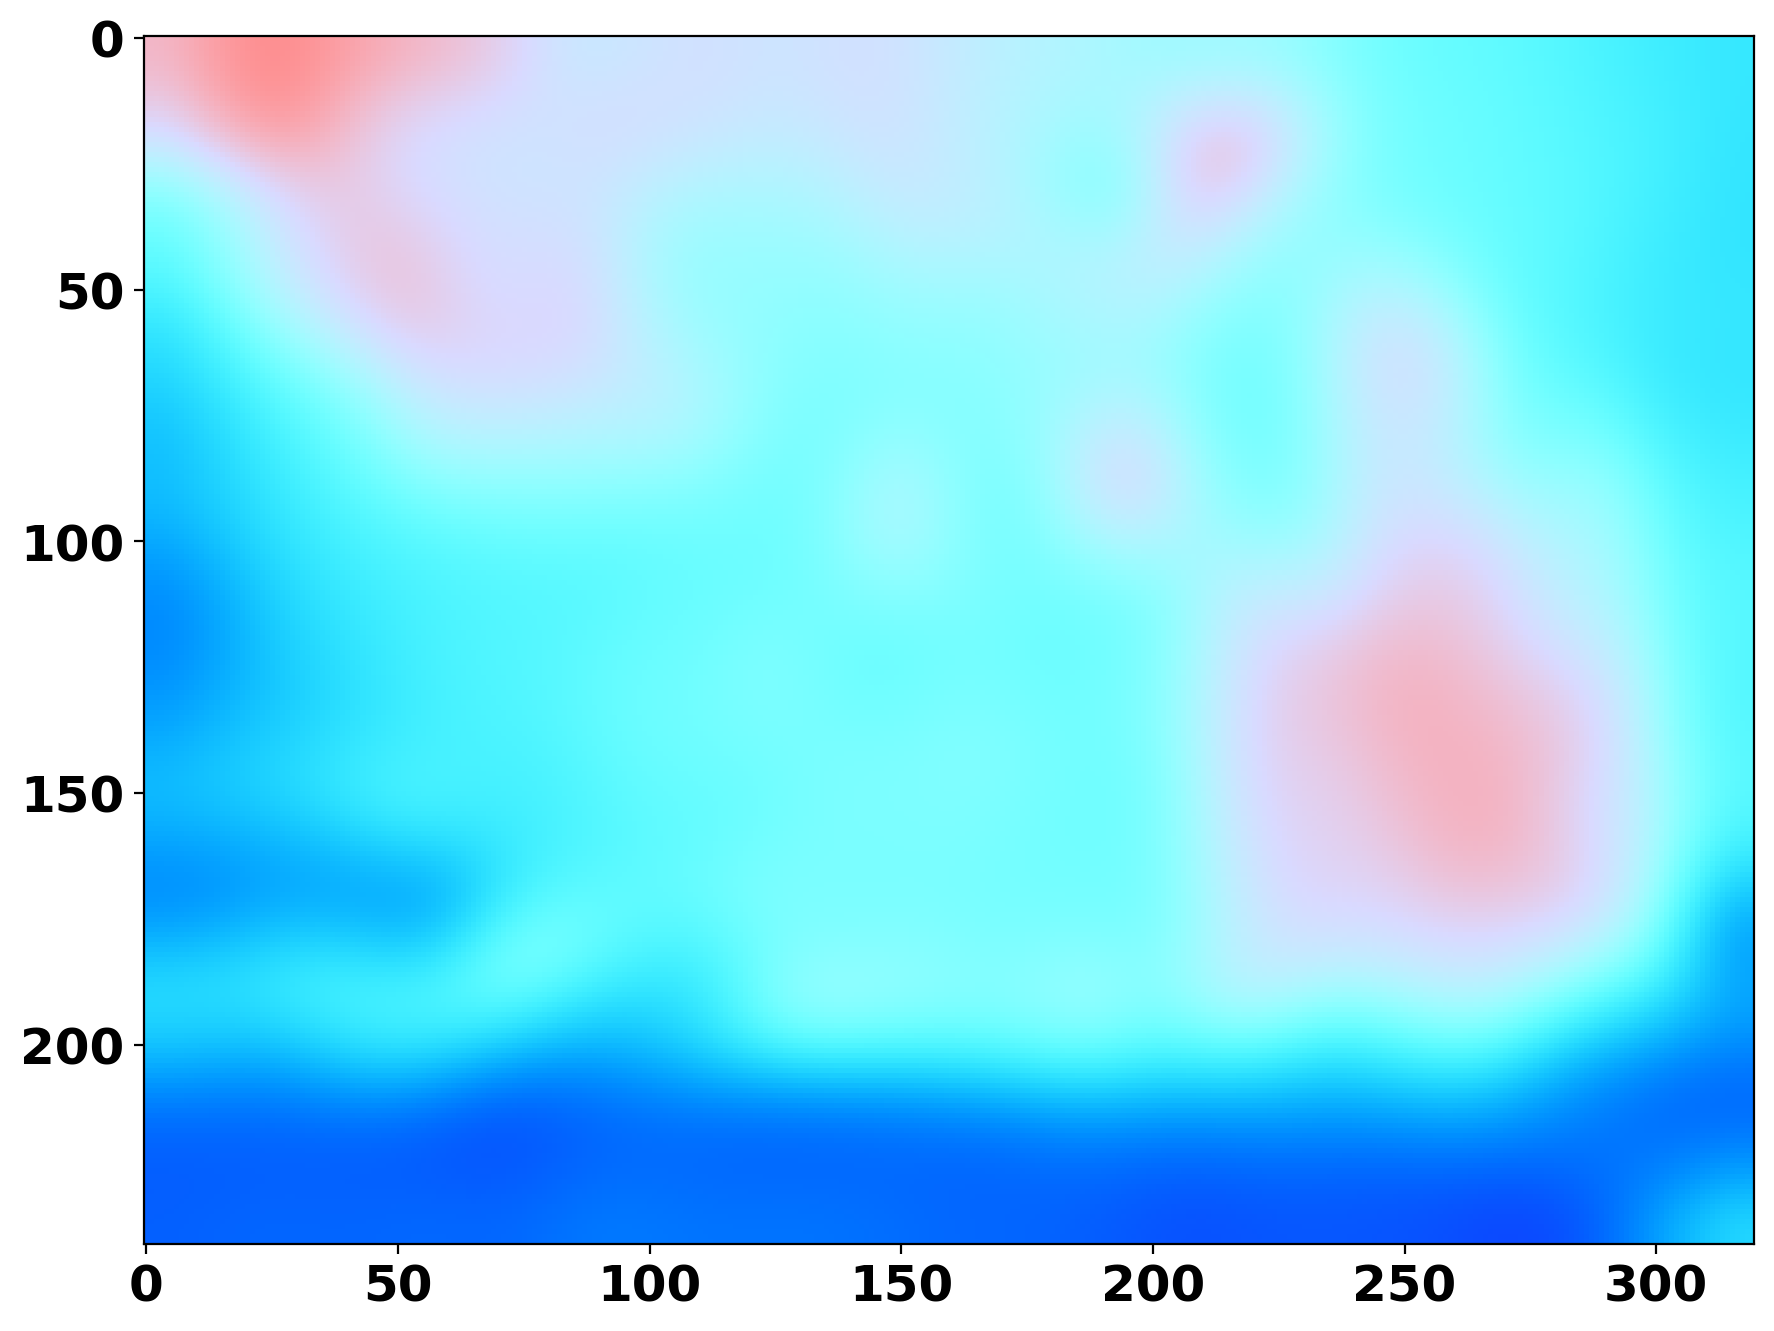

In [46]:
# #Brewster's angleを手掛かりに位相を求める (法線方向は 0~1⇒0~2π)
min_phase_img = np.argmin(frames[start_idx:end_idx,:,:,1],axis=0)/period*2*np.pi
size = 10 # 2
min_phase_img = cv2.GaussianBlur(min_phase_img, [0,0],size)
normal_map = np.zeros([h,w,3])
normal_map[:,:,0] = 0.5+0.5*np.cos(min_phase_img[:,:]) # X
normal_map[:,:,1] = 0.5+0.5*np.sin(min_phase_img[:,:]) # Y
normal_map[:,:,2] = np.sqrt(1-normal_map[:,:,0]**2+normal_map[:,:,1]**2)
plt.imshow(normal_map);plt.show()


plt.rcParams["font.size"] = 18
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.figure(figsize=(12,8), dpi=200 )
plt.imshow(normal_map);plt.show()

## リライティング処理

### 元の照明

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


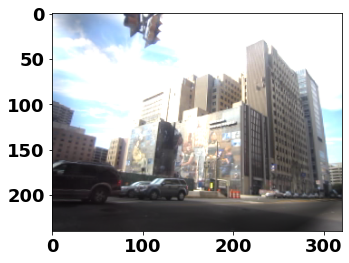

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


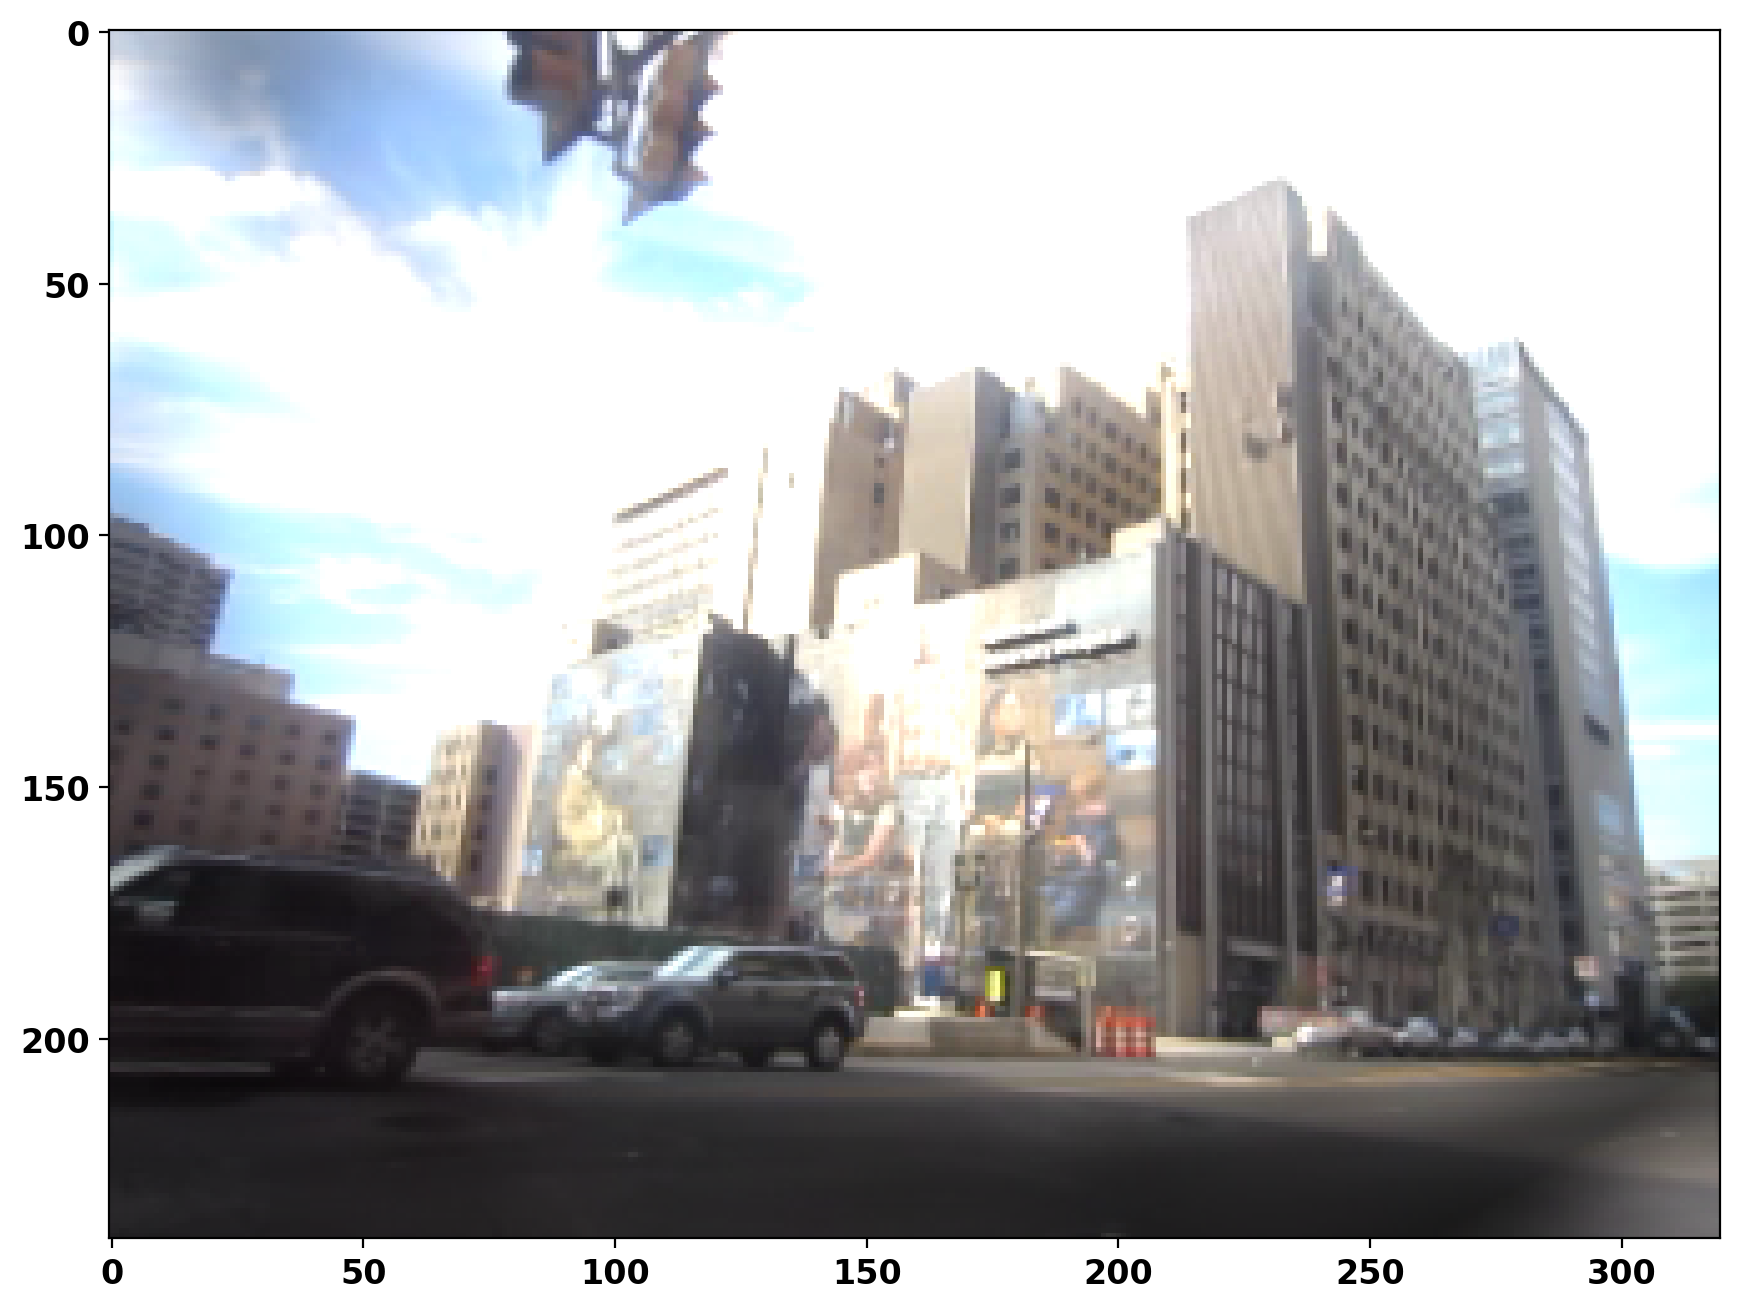

In [52]:
light_angle = np.pi/2 # 照明方向（反時計回り、正午が0）
spc_light_ratio = 2.0 # 鏡面反射光比率
ref_light_ratio = 2.0 # 内部拡散光比率
ref_light_gamma = 1.0 # 内部拡散光のガンマ
relight_img = np.zeros([h,w,3]) # 照明偏光画像
inner_product = (1.0+1.0*np.cos(min_phase_img[:,:]-light_angle))/2.0
for i in range(3):
    relight_img[:,:,i] =  \
    +  ref_light_ratio*min_img[:,:,i]*ref_light_gamma*inner_product \
    +  spc_light_ratio*inner_product*spc_img[:,:,i] 
plt.imshow(relight_img/255/1.5); plt.show()


plt.rcParams["font.size"] = 12
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.figure(figsize=(12,8), dpi=200 )
plt.imshow(relight_img/255/1.5); plt.show()

relight_img2 = relight_img

#### 反対側の照明

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


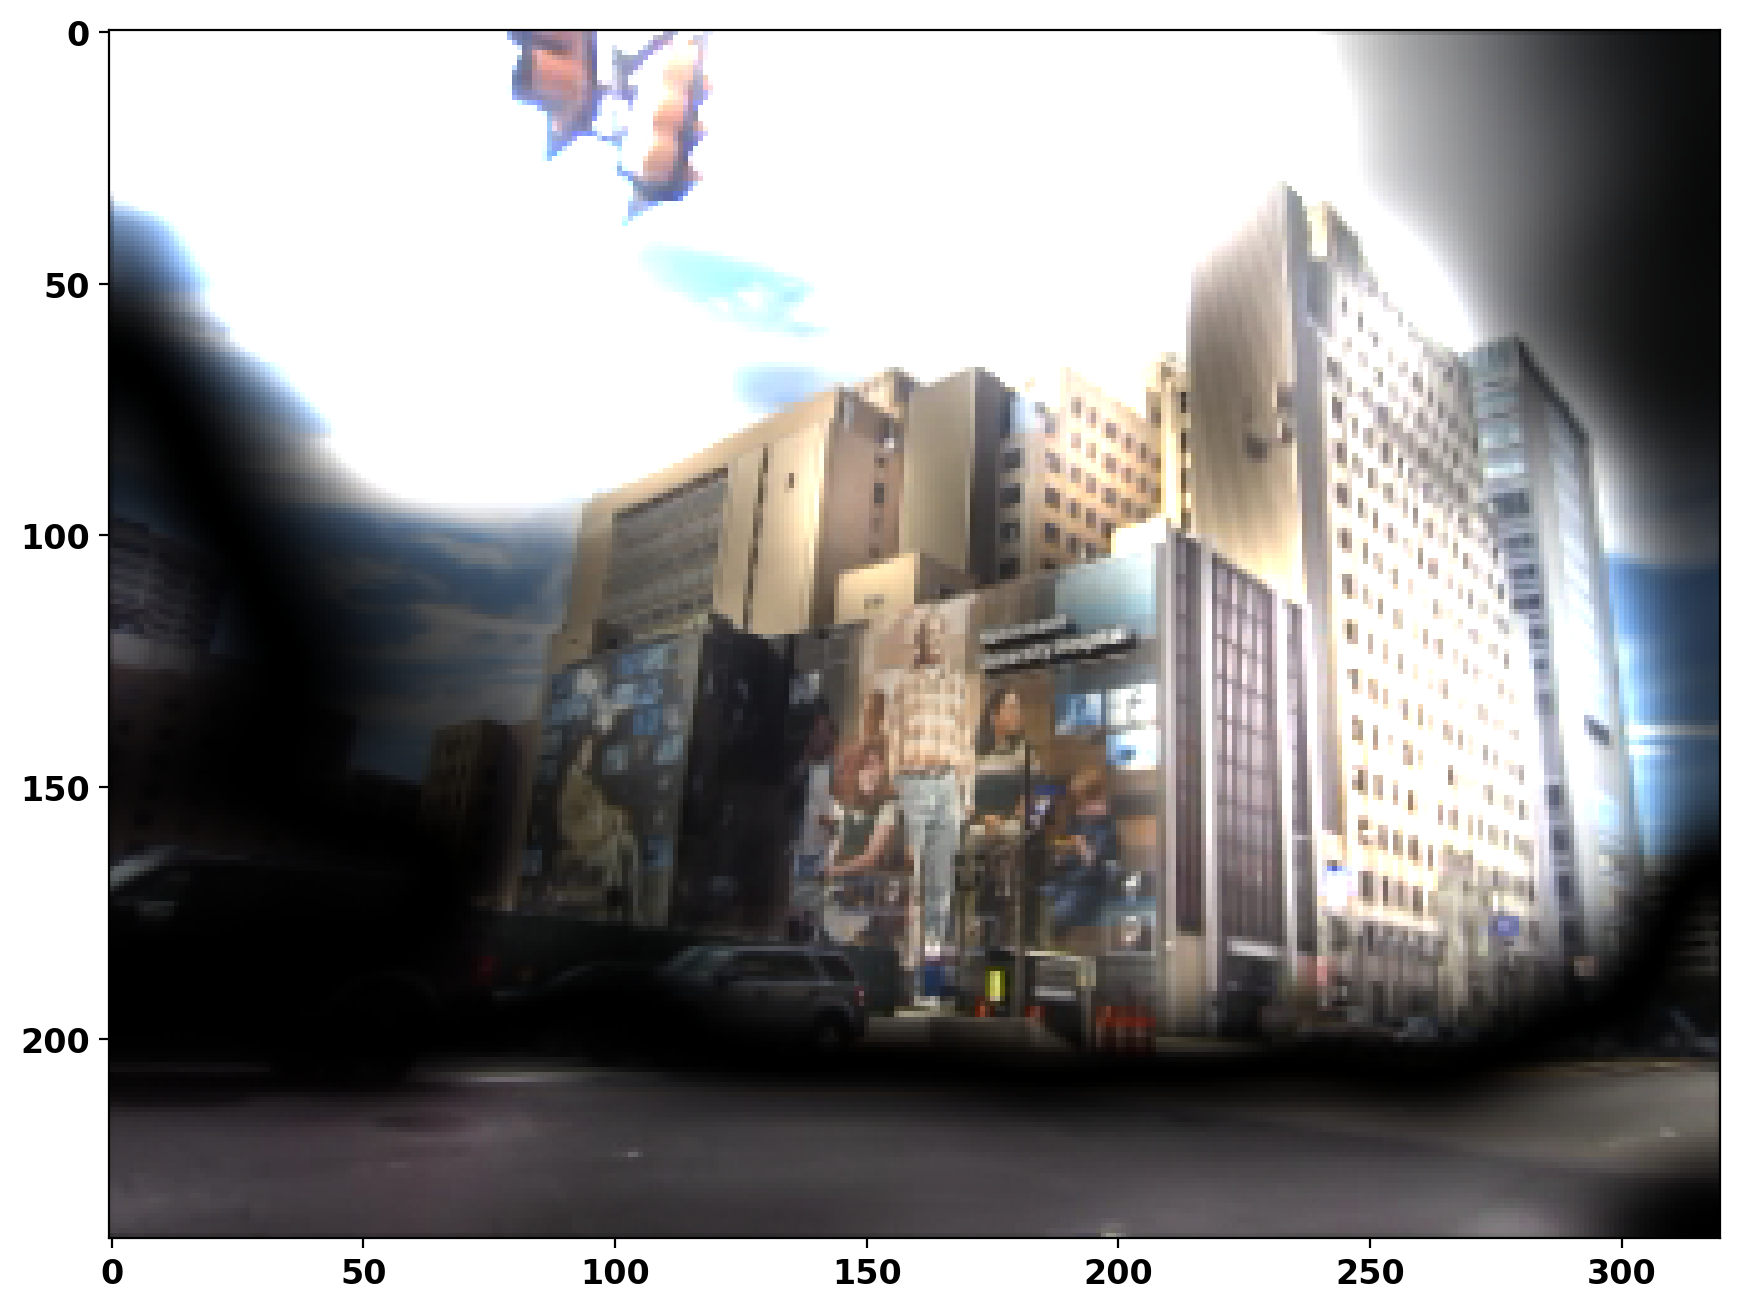

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


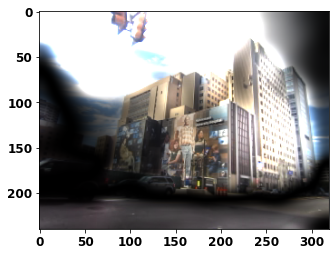

In [58]:
# 照明方向
light_angle = -np.pi/4 # 反時計回り、正午が0

# 内部拡散光に、内部拡散光に対する照明影響を加える
spc_light_ratio = 2.0*2
ref_light_gamma = 1.2
ref_light_ratio = 2*6

relight_img = np.zeros([h,w,3])
inner_product = (1.0+1.0*np.cos(min_phase_img[:,:]-light_angle))/2.0
for i in range(3):
    #relight_img[:,:,i] = min2_img[:,:,i] \#*light_ratio**inner_product \
    relight_img[:,:,i] = \
       +  ref_light_ratio*255*((min_img[:,:,i]/255)**ref_light_gamma)*inner_product \
       +  spc_light_ratio*inner_product*spc_img[:,:,i]

plt.rcParams["font.size"] = 12
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.figure(figsize=(12,8), dpi=200 )
plt.imshow(relight_img/255/1.5); plt.show()
plt.imshow(relight_img/255/1.5)
plt.show()
relight_img1 = relight_img

#### 照明合成

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


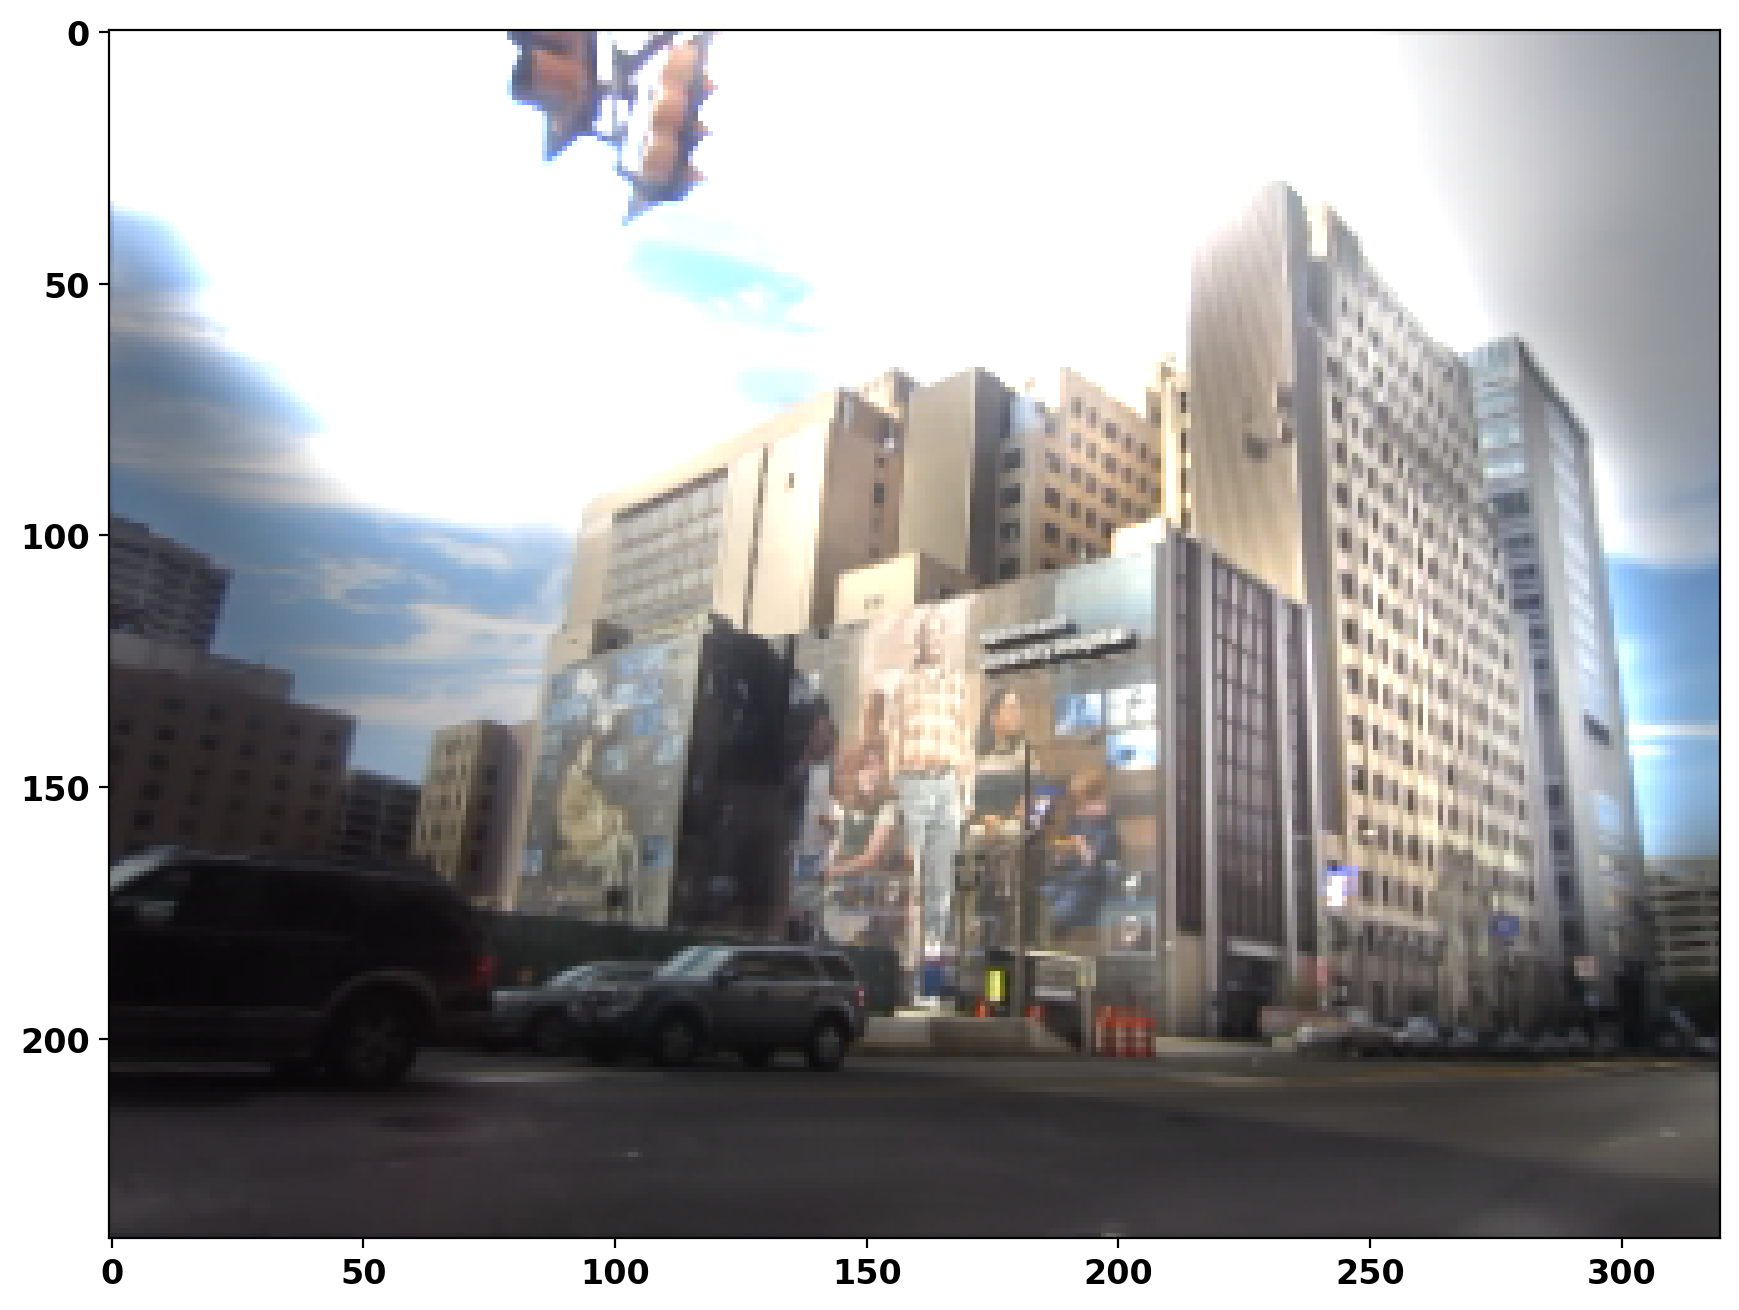

In [59]:
plt.rcParams["font.size"] = 12
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.figure(figsize=(12,8), dpi=200 )


plt.imshow(relight_img1/255/3+relight_img2/255/3)
plt.show()